In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os, glob
from scipy.optimize import minimize
from scipy.stats import beta as beta_dist
from scipy.stats import beta as Beta


models

In [2]:
def gauss(params, normed_stim):
    '''gauss noise'''
    sigma = params[0]
    mu = normed_stim
    return mu, np.full_like(normed_stim, sigma)

def gauss_bias(params, normed_stim):
    '''gauss noise + bias'''
    sigma, bias = params
    mu = normed_stim + bias
    return mu, np.full_like(normed_stim, sigma)

def beta_const_noise(params, normed_stim, EPS=1e-9):
    """const noise, kappa"""
    (kappa,) = params
    mu = np.clip(normed_stim.astype(float), EPS, 1-EPS) # guards endpoints
    a  = mu * kappa
    b  = (1 - mu) * kappa
    return a, b

def beta_var_noise(params, normed_stim, EPS=1e-9):
    ''' stim-dependent noise (kappa)'''
    eta0, eta1 = params
    mu = np.clip(normed_stim.astype(float), EPS, 1-EPS)          # clip μ

    # kappa varies with distance from boundary (-.5 bc normed)
    kappa = softplus(eta0 + eta1 * np.abs(mu - 0.5)) + 1e-6 # κ>0
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

def beta_logistic(params, normed_stim, EPS=1e-9):
    ''' logistic mean, const kappa '''
    # bias, slope, noise param for kappa
    w0, w1, eta = params

    # logistic
    mu = 1.0 / (1.0 + np.exp(-(w0 + w1*(normed_stim - 0.5))))
    mu = np.clip(mu.astype(float), EPS, 1-EPS)
    
    # const kappa
    kappa = softplus(eta) + 1e-6
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

def norm01(x, lo=-.38, hi=.38):
    '''Normalize input to [0,1] range.'''
    normed = (x - lo) / (hi - lo)
    clipped = np.clip(normed, 1e-6, 1-1e-6)
    return clipped

def inv_norm01(y, lo=-.38, hi=.38):
    """Map [0,1] back to [lo,hi]."""
    return lo + y * (hi - lo)

def softplus(z): return np.log1p(np.exp(z))


fitting & comparing functions

In [3]:
def gauss_ll(gauss_model, params, normed_stim, normed_resp):
    '''Log-likelihood for Gaussian continuous responses.'''
    mu, sigma = gauss_model(params, normed_stim)
    resid = normed_resp - mu

    ll = -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (resid**2)/(sigma**2))
    return ll

def beta_ll(beta_model, params, normed_stim, normed_resp, EPS=1e-9):
    '''Log-likelihood for Beta continuous responses.'''
    a, b = beta_model(params, normed_stim)
    normed_resp = np.clip(normed_resp.astype(float), EPS, 1 - EPS)  # guard endpoints
    ll = np.sum(beta_dist.logpdf(normed_resp, a=a, b=b))
    return ll

def fit_model(model, stim, resp, init_params, bounds):
    '''Fit a model to the data by minimizing the negative log-likelihood.'''

    # choose the right likelihood function
    ll_func = beta_ll if model in beta_models else gauss_ll

    # wrapper: given parameters, compute *negative* log-likelihood
    def nll(theta):
        loglik = ll_func(model, theta, norm01(stim), norm01(resp))
        return -loglik
    
    result = minimize(nll, init_params, bounds=bounds)
    return result.x, -result.fun # params, -ll

def bic(loglik, num_params, num_trials):
    '''Bayesian Information Criterion (BIC) for model comparison.'''
    return -2*loglik + num_params * np.log(num_trials)


data

In [4]:
# REAL
df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
df_baseline = df[df['condition']=='baseline'].copy()
stim = df['stim_pos_aligned'].values
resp = df['chosen_pos_aligned'].values
div = df['div_pos_aligned'].values
normed_stim, normed_resp = norm01(stim), norm01(resp)


fitting data

In [5]:
# model families
beta_models = {beta_const_noise, beta_var_noise, beta_logistic}
gauss_models = {gauss, gauss_bias}

# models to run
models_info = [
    (gauss,             [0.5],              [(1e-6, None)]),                     # sigma
    (beta_const_noise,  [5.0],              [(1e-6, None)]),                     # kappa (const noise)
    (beta_var_noise,    [1.0, 0.0],         [(None, None), (None, None)]),       # eta0, eta1 (base noise, stim-dependent noise)
    (beta_logistic,     [0.0, 3.0, 1.0],    [(None,None),(None,None),(None,None)]) # w0, w1, eta (bias, slope, const noise)
]

# storing recovered metrics
model_metrics = {}
for model, init, bounds in models_info:
    params, ll = fit_model(model, stim, resp, init_params=init, bounds=bounds)
    model_metrics[model] = {'params': params, 'LL': ll, 'BIC': bic(ll, len(params), len(stim))}

# print
for model, metrics in model_metrics.items():
    print(model.__name__)
    for metric, val in metrics.items():
        print(metric, val)
    print()


gauss
params [0.20989787]
LL 204.76171519627692
BIC -402.2510319999838

beta_const_noise
params [2.85002276]
LL -1395.7623888463977
BIC 2798.7971760853657

beta_var_noise
params [1.209094   6.88025472]
LL -1329.8215551352846
BIC 2674.1879070557093

beta_logistic
params [-0.04532754  2.93414477  2.37503349]
LL 448.9263781283288
BIC -876.0355610789475



plots

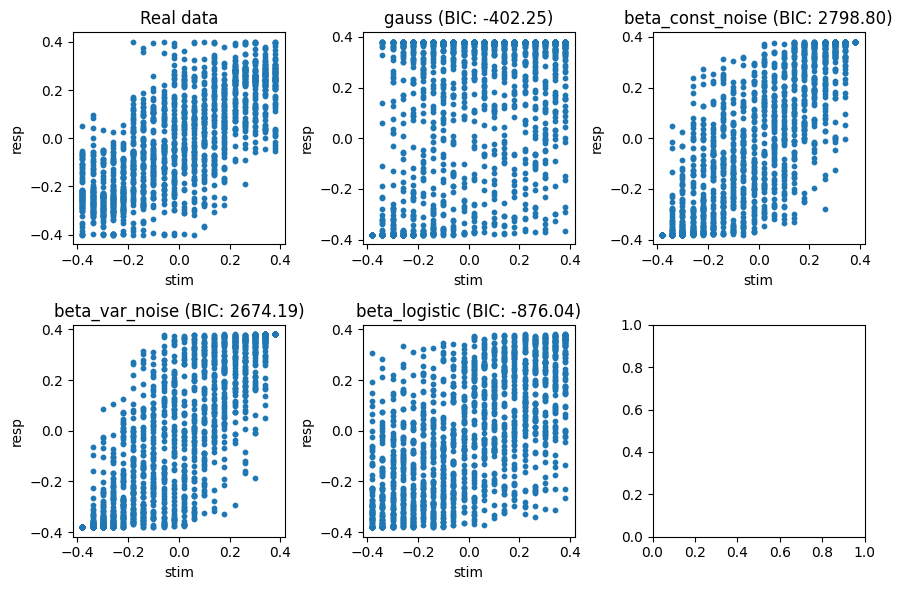

In [6]:
rows = 2
fig, axs = plt.subplots(rows, 3, figsize=(3*3, 3*rows))
axs, ax = axs.flatten(), 0

# real data
axs[ax].scatter(stim, resp, s=10)
axs[ax].set(title='Real data', xlabel='stim', ylabel='resp')
ax += 1

# simulated data
for model in model_metrics:
    
    # recover
    fit_params = model_metrics[model]['params']
    BIC = model_metrics[model]['BIC']

    
    a, b = model(fit_params, norm01(stim)) # pass normed stim
    sim_resp = inv_norm01(np.random.beta(a, b)) # recover unnormed resp
    axs[ax].scatter(stim, sim_resp, s=10)
    axs[ax].set(title=f'{model.__name__} (BIC: {BIC:.2f})', xlabel='stim', ylabel='resp')
    ax += 1

plt.tight_layout()
plt.show()

posterior predictive checks

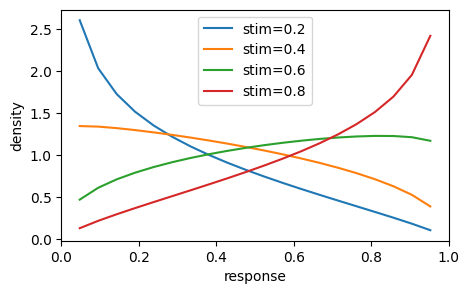

In [7]:

# stim
rand_stims = [.2, .4, .6, .8]

# logistic fitted params
logistic_params = model_metrics[beta_logistic]['params']
logistic_params

# a, b given stim & params
a, b = beta_logistic(logistic_params, np.array(rand_stims))

resp_x = np.linspace(0, 1, 22)[1:-1]

plt.figure(figsize=(5,3))
for stim_i, a_i, b_i in zip(rand_stims, a, b):
    plt.plot(resp_x, Beta(a_i, b_i).pdf(resp_x), label=f"stim={stim_i:.1f}")
plt.xlabel("response")
plt.xlim(0,1)
plt.ylabel("density")
plt.legend()
plt.show()
